# Plot IUPRED3 scores for clouds
Inspect sequences of length up to 600, split them in half by the ratio of bad pLDDTs and color clouds by IUPRED3 score

In [1]:
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_with_outliers = pd.concat(dfs)

In [18]:
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'iupred_auc_normalized' in proteome_df:
        continue
    proteome_df['iupred_auc_normalized'] = np.round(proteome_df['iupred_auc'] / proteome_df['seq_len'], decimals=4)
    proteome_df.to_csv(proteome_file)

In [20]:
df_with_outliers = df_with_outliers[df_with_outliers['seq_len'] < 600]
df_with_outliers = df_with_outliers[df_with_outliers['iupred_auc'].notnull()]
df_with_outliers.nlargest(n=10, columns='iupred_auc_normalized')

,uniprot_id,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,...,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,iupred_auc_normalized,proteome,cluster_id,suboptim_compress
20510,E9PWP7,378,1.0,40.86,84.6046,89.955,0.1534,2730.6999,-0.142760,0.0,...,0.143250,0.1111,0.1190,0.4788,0.2910,5.3808,7.2241,MOUSE,NaN,NaN
15009,Q08AU9,97,1.0,25.50,61.7270,64.020,0.7113,157.9724,0.618561,0.0,...,0.191957,0.2371,0.0515,0.4948,0.2165,10.9208,1.6286,MOUSE,NaN,NaN
1794,A0A5K4F6S0,68,0.0,51.87,63.5184,63.695,0.9118,69.3653,0.080402,41.0,...,0.574576,0.0000,0.7353,0.1765,0.0882,4.0500,1.0201,SCHMA,NaN,NaN
9699,A0A0R4ILF4,25,0.0,65.35,94.5168,96.730,0.0400,25.4887,0.483846,0.0,...,0.587367,0.6800,0.0000,0.2400,0.0800,12.0000,1.0195,DANRE,NaN,NaN
1884,P62947,25,0.0,64.88,94.3656,96.660,0.0400,25.4887,0.525385,0.0,...,0.587367,0.6800,0.0000,0.2400,0.0800,12.0000,1.0195,MOUSE,NaN,NaN
11540,A0A5K4EP43,64,0.0,64.23,79.1627,81.385,0.1406,65.0331,0.565980,0.0,...,0.459937,0.5312,0.0625,0.1406,0.2656,11.5293,1.0161,SCHMA,NaN,NaN
6017,A0A0K0E6Y1,87,0.0,38.51,55.9576,51.840,0.8391,88.3691,-0.669455,0.0,...,0.572463,0.5747,0.2874,0.0575,0.0805,6.1834,1.0157,STRER,NaN,NaN
3102,X8F7E7,40,0.0,64.02,72.2935,71.890,0.3000,40.3720,0.131895,0.0,...,0.426729,0.1500,0.3000,0.5000,0.0500,4.2359,1.0093,MYCUL,NaN,NaN
5318,A0A0N4URX1,226,0.0,28.62,40.7413,41.270,1.0000,228.0693,-0.121998,0.0,...,0.593936,0.0664,0.6637,0.1195,0.1504,4.0500,1.0092,DRAME,NaN,NaN
7445,Q20693,87,0.0,40.51,49.0501,49.520,1.0000,87.6582,0.386724,0.0,...,0.507408,0.3678,0.2414,0.2414,0.1494,5.7570,1.0076,CAEEL,NaN,NaN


In [4]:
# Remove outlier
df = df_with_outliers[df_with_outliers['iupred_auc_normalized'] < 1.6]

In [16]:
print(df_with_outliers['cluster_id_x'].equals(df_with_outliers['cluster_id_y']))

True


In [5]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['iupred_auc_normalized'])
print(f'Spearman rank correlation: {"{0:.4f}".format(rho)}')

Spearman rank correlation: 0.5059


In [6]:
%matplotlib notebook
fig = plt.figure()

ax = plt.axes(projection='3d')
p = ax.scatter(df['ratio_bad_plddt'], df['median_plddt'], df['mean_plddt'], c=df['iupred_auc_normalized'], cmap='viridis')
ax.set_xlabel("Ratio bad pLDDT")
ax.set_ylabel("Median pLDDT")
ax.set_zlabel("Mean pLDDT")
fig.colorbar(p, ax=ax)
plt.show()

<IPython.core.display.Javascript object>

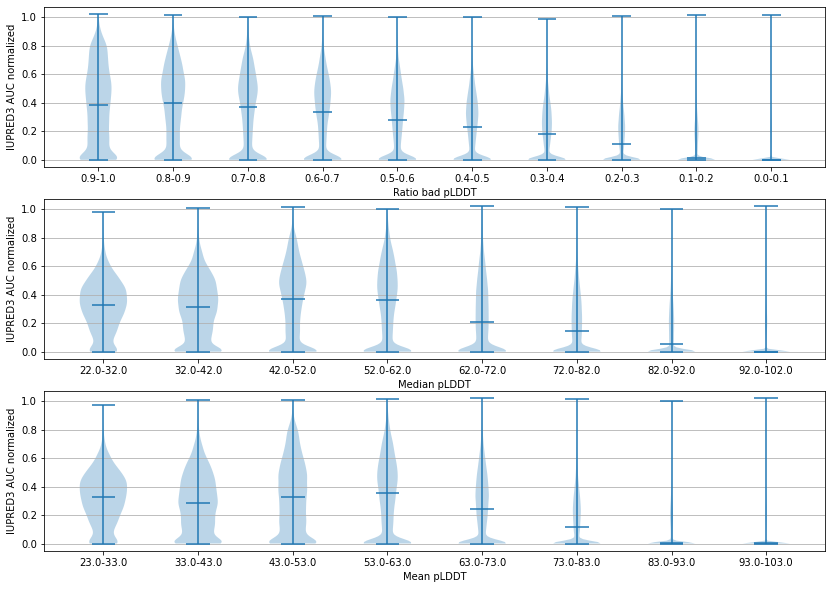

In [6]:
%matplotlib inline
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(14, 10))

def violin_plot(ax, prop, title, bucket_step_size, decimals=0):
    buckets_indices = np.arange(np.floor(df[prop].min()), df[prop].max(), bucket_step_size)
    buckets = [df[df[prop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    ax.violinplot(dataset = [bucket['iupred_auc_normalized'].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel(title)
    ax.set_ylabel('IUPRED3 AUC normalized')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

violin_plot(ax1, 'ratio_bad_plddt', 'Ratio bad pLDDT', 0.1, decimals=1)
ax1.invert_xaxis()
violin_plot(ax2, 'median_plddt', 'Median pLDDT', 10)
violin_plot(ax3, 'mean_plddt', 'Mean pLDDT', 10)

plt.show()

### Investigate 6mer frequency as fallback for bad IUPRED

In [8]:
df_with_outliers.nlargest(1000, columns=['ratio_bad_plddt']).nsmallest(1000, columns=['iupred_auc'])[['uniprot_id', 'ratio_bad_plddt', 'iupred_auc']].to_csv('../data/alphafold/bad_alphafold_good_iupred.csv', index=None)